**Team: Spatial Extent**

*Challenge 3*

Visual Question Answering


# Import and downloads

In [ ]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
import json
import pandas as pd
import math

In [ ]:
SEED = 1234
tf.random.set_seed(SEED)  
np.random.seed(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks"

In [ ]:
%cd /content/

/content


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=7614d5feff46bbcc3edc75950fccc2a815a6c428fc0cac82b8fc97990da986c2
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [ ]:
!kaggle competitions download -c anndl-2020-vqa

100% 3.96G/3.97G [01:28<00:00, 74.6MB/s]
100% 3.97G/3.97G [01:28<00:00, 48.4MB/s]


In [ ]:
!unzip /content/anndl-2020-vqa.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: VQA_Dataset/Images/5390.png  
  inflating: VQA_Dataset/Images/5391.png  
  inflating: VQA_Dataset/Images/5392.png  
  inflating: VQA_Dataset/Images/5393.png  
  inflating: VQA_Dataset/Images/5394.png  
  inflating: VQA_Dataset/Images/5395.png  
  inflating: VQA_Dataset/Images/5396.png  
  inflating: VQA_Dataset/Images/5397.png  
  inflating: VQA_Dataset/Images/5398.png  
  inflating: VQA_Dataset/Images/5399.png  
  inflating: VQA_Dataset/Images/54.png  
  inflating: VQA_Dataset/Images/540.png  
  inflating: VQA_Dataset/Images/5400.png  
  inflating: VQA_Dataset/Images/5401.png  
  inflating: VQA_Dataset/Images/5402.png  
  inflating: VQA_Dataset/Images/5403.png  
  inflating: VQA_Dataset/Images/5404.png  
  inflating: VQA_Dataset/Images/5405.png  
  inflating: VQA_Dataset/Images/5406.png  
  inflating: VQA_Dataset/Images/5407.png  
  inflating: VQA_Dataset/Images/5408.png  
  inflating: VQA_Dataset/Images/5409.png  
  infla

# Data Preparation

In [ ]:
def read_questions(path):
  with open(path, 'r') as file:
    qs = json.load(file)
  texts = [qs[q]['question'] for q in qs]
  answers = [qs[q]['answer'] for q in qs]
  image_ids = [qs[q]['image_id'] for q in qs]
  return (texts, answers, image_ids)

In [ ]:
train_qs, train_answers, train_image_ids = read_questions('/content/VQA_Dataset/train_questions_annotations.json')

Shuffle

In [ ]:
len(train_qs)

58832

In [ ]:
len(train_image_ids)

58832

In [ ]:
indices = np.arange(len(train_qs))
np.random.shuffle(indices)

train_qs = np.array(train_qs)
train_answers = np.array(train_answers)
train_image_ids = np.array(train_image_ids)

train_qs = train_qs[indices]
train_answers = train_answers[indices]
train_image_ids = train_image_ids[indices]


In [ ]:
len(train_qs)

58832

In [ ]:
len(train_image_ids)

58832

##Tokenization

In [ ]:
MAX_NUM_WORDS = 20000

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create Tokenizer to convert words to integers
qs_tokenizer = Tokenizer(num_words= MAX_NUM_WORDS)
qs_tokenizer.fit_on_texts(train_qs)
qs_tokenized = qs_tokenizer.texts_to_sequences(train_qs)

qs_wtoi = qs_tokenizer.word_index
print('Total qs words:', len(qs_wtoi))

max_qs_length = max(len(sentence) for sentence in qs_tokenized)#21
#max_qs_length = 15
print('Max qs sentence length:', max_qs_length)

Total qs words: 4640
Max qs sentence length: 21


<BarContainer object of 22 artists>

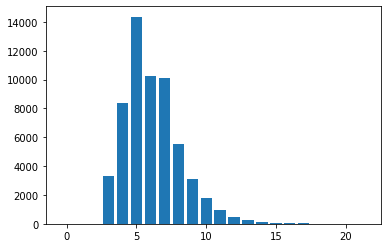

In [ ]:
lens = np.zeros([21+1])
for sentence in qs_tokenized:
  lens[len(sentence)] += 1

import matplotlib.pyplot as plt
plt.bar(np.arange(len(lens)),lens) 

Considering the fact the most of questions are with < 15 words, we considered the idea of cutting them at 15 words, but this has a negligible effect on the number of parameters and no useful effect at the end

In [ ]:
# Pad to max qs sentence length
qs_inputs = pad_sequences(qs_tokenized, maxlen=max_qs_length)

print("QS inputs shape:", qs_inputs.shape)

QS inputs shape: (58832, 21)


## Split valid-train

In [ ]:
val_split = 0.01

num_elems = len(qs_inputs)
print(f"There are {num_elems} elements")

train_elems = math.ceil(num_elems * (1 - val_split))
valid_elems = math.floor(num_elems * val_split)

valid_qs = qs_inputs[-valid_elems:]
valid_answers = train_answers[-valid_elems:]
valid_image_ids = train_image_ids[-valid_elems:]

train_qs = qs_inputs[0:train_elems]
train_answers = train_answers[0:train_elems]
train_image_ids = train_image_ids[0:train_elems]

print(f"{train_elems} in the training set, {valid_elems} in the valid set")

There are 58832 elements
58244 in the training set, 588 in the valid set


In [ ]:
len(train_image_ids)

58244

In [ ]:
len(train_qs)

58244

In [ ]:
c = 0
for i in train_image_ids:
  if i in valid_image_ids:
    c += 1
print(c)

787


In [ ]:
valid_qs

array([[   0,    0,    0, ...,   27,    1,   16],
       [   0,    0,    0, ...,    7,    1,   81],
       [   0,    0,    0, ...,   27,    1,   34],
       ...,
       [   0,    0,    0, ...,    1,   15, 1929],
       [   0,    0,    0, ...,    2,    1,  268],
       [   0,    0,    0, ...,    1,  438,  152]], dtype=int32)

In [ ]:
labels_dict = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

## Dataset

In [ ]:
img_w = 448
img_h = 448

Not actually used, but we tried a small data augmentation that should not have altered most of the answers, as explained in the report

In [ ]:
train_img_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=[-20,20],
                                  #height_shift_range=[-20,20],
                                  zoom_range=[0.9,1.2],
                                  horizontal_flip=True,
                                  fill_mode='constant', 
                                  cval=0,
                                  )

In [ ]:
class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, which_subset, img_dir, img_generator=None, 
               preprocessing_function=None, out_shape=[img_h, img_w]):
    if which_subset == 'training':
      self.qs = train_qs
      self.answers = train_answers
      self.image_ids = train_image_ids
    elif which_subset == 'validation':
      self.qs = valid_qs
      self.answers = valid_answers
      self.image_ids = valid_image_ids


    self.which_subset = which_subset
    self.img_dir = img_dir
    self.img_generator = img_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.qs)

  def __getitem__(self, index):
    img_path = os.path.join(self.img_dir,self.image_ids[index]+'.png')
    img = Image.open(img_path).convert('RGB') #convert is necessary, otherwise PNG have 4 channels
    qs = self.qs[index]
    answer = labels_dict[self.answers[index]]

    # Resize image
    img = img.resize(self.out_shape)
    
  
    img_arr = np.array(img)

    if self.which_subset == 'training':
      if self.img_generator is not None:
        # Perform data augmentation
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
    
    if self.preprocessing_function is not None:
      img_arr = self.preprocessing_function(img_arr)
    else:
      img_arr = img_arr / 255.0

    return {'Input_img':img_arr, 'Input_qs':qs}, answer

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input 

img_dir = '/content/VQA_Dataset/Images'

dataset = CustomDataset('training', 
                        img_generator=None, img_dir=img_dir,
                        preprocessing_function=preprocess_input)
dataset_valid = CustomDataset('validation', img_dir=img_dir, img_generator=None,
                              preprocessing_function=preprocess_input)

In [ ]:
bs=32

In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=({'Input_img':tf.float32,'Input_qs': tf.int32},tf.int32),
                                               output_shapes=({'Input_img':[None, None, 3],'Input_qs':[max_qs_length]}, []))

train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=({'Input_img':tf.float32,'Input_qs': tf.int32},tf.int32),
                                               output_shapes=({'Input_img':[None, None, 3],'Input_qs':[max_qs_length]}, []))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

## Load test

In [ ]:
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

iterator = iter(train_dataset)

Q:where is the beehive  A:tree


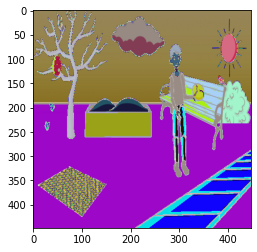

In [ ]:
fig, ax = plt.subplots(1, 1)

inputs, answer = next(iterator)
img = inputs['Input_img'][0] #take first of batch
qs = inputs['Input_qs'][0]
answer = answer[0]

qs_string = ""
qs_itow = {v:k for k, v in qs_wtoi.items()}
for i in qs.numpy():
  if i > 0:
    word = qs_itow[i]
    qs_string += word + " "

answer_string = (list(labels_dict.keys())[list(labels_dict.values()).index(answer)])

print(f"Q:{qs_string} A:{answer_string}")

plt.imshow(np.uint8(img))

plt.show()

# Glove

The 3 following cells allow to import Glove, but it the final model it's not used and so their execution can be avoided

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-01-18 08:47:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-01-18 08:47:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-18 08:47:32--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
EMBEDDING_DIM = 300
GLOVE_DIR = "/content/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [ ]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(qs_wtoi) + 1, EMBEDDING_DIM))
for word, i in qs_wtoi.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/glove.6B.300d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


# Model

We report the code for all the models we tried, but the final results are obtained with the **Co-Attention** model

## First Model

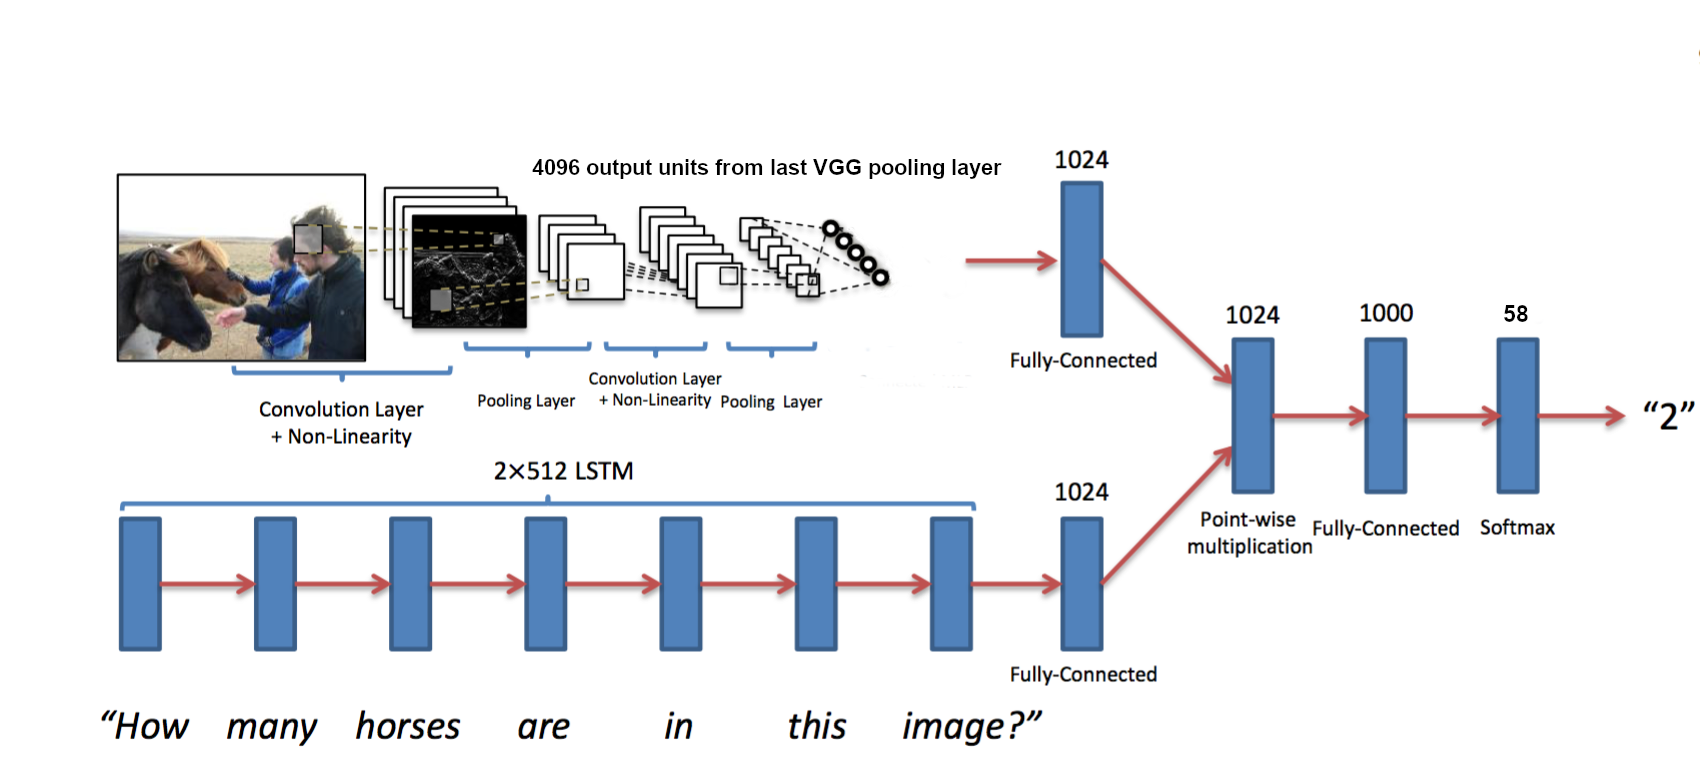

In [ ]:
from keras.layers import Dense, Activation, Dropout, LSTM, Flatten, Embedding, Multiply, Concatenate, GRU
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import Model, Input

def RNN_1(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate):
    input = Input(shape=[max_qs_length],name="Input_qs")
 
    #if embedding_matrix != None:
      #PRETRAINED-GLOVE EMBEDDING   
    #x = Embedding(num_words, embedding_dim, 
        #weights=[embedding_matrix], input_length=seq_length, trainable=False)(input)
      #print('GLOVE')
    #else:
      #LEARNED EMBEDDING
    x = Embedding(num_words,embedding_dim,input_length=seq_length)(input)

    x = GRU(units=512, return_sequences=True, input_shape=(seq_length, embedding_dim))(x)
    x = Dropout(dropout_rate)(x)
    x = GRU(units=512, return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(1024, activation='tanh')(x)
    model = Model([input],x)
    return model

def img_model_1(dropout_rate):
    
    vgg = tf.keras.applications.VGG19(
        include_top=False,
        weights="imagenet"
    )
    for l in vgg.layers:
      l.trainable = False
    vgg.layers.pop(0)
    input = Input(shape=[img_h,img_w,3],name="Input_img")
    x = vgg(input)
    x = Flatten()(x)
    x = Dense(1024, input_dim=4096, activation='tanh')(x)
    model = Model([input],x)
    return model

def vqa_model_1(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate, num_classes):
    vgg_model = img_model(dropout_rate)
    lstm_model = RNN(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate)
    x = Multiply()([vgg_model.outputs[0], lstm_model.outputs[0]])
    x = Dropout(dropout_rate)(x)
    x = Dense(1000, activation='tanh')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(num_classes, activation='softmax')(x)

    fc_model = Model([vgg_model.input,lstm_model.input],x)
    return fc_model

## Stacked Attention

Stacked Attention Network proposed in https://arxiv.org/pdf/1511.02274.pdf  (Zichao Yang, Xiaodong He, Jianfeng Gao, Li Deng, Alex Smola - *Stacked Attention Networks for Image Question Answering* )

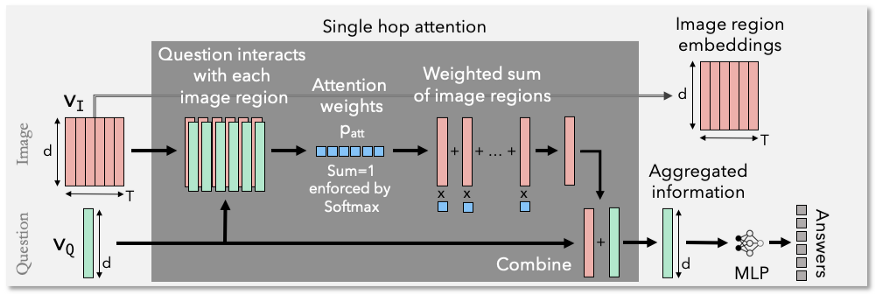

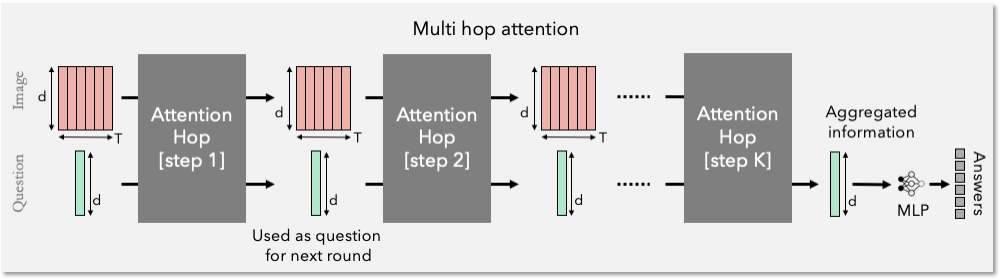

In [ ]:
def attention(image_tensor , question_tensor , out_dim  , dropout, dropout_rate, n=0):
    
    img = tf.keras.layers.Dense(out_dim, activation='tanh')(image_tensor)

    print(f"img_shape={img.shape}") #img_shape=(None, 14, 14, 512)

    img = tf.keras.layers.Reshape((-1,out_dim))(img)  
    
    print(f"img_reshape={img.shape}") #img_reshape=(None, 196, 512) 196=m, 512=d
   
    ques = tf.keras.layers.Dense(out_dim, activation='tanh')(question_tensor) 

    print(f"ques_shape={ques.shape}")  #ques_shape=(None, 512)

    
    ques_r = tf.keras.layers.Reshape((1,out_dim))(ques)
    print(f"ques_re_shape={ques_r.shape}") #ques_re_shape=(None, 1, 512) necessary to do the following addition, where the m-th ques vector is summed over every column of the img matrix
    
    sum = tf.keras.layers.Activation('tanh',name='sum_ques_img_'+str(n))(img + ques_r)

    print(f"sum_shape={sum.shape}") #(None, 196, 512)
     
    if dropout:
        sum = tf.keras.layers.Dropout(dropout_rate)(sum)
    
    temp = tf.keras.layers.Dense(1)(sum) 

    print(f"temp_shape={temp.shape}") #temp_shape=(None, 196, 1) now we need to reduce to a value for each of the m regions of the image
    
    temp = tf.keras.layers.Reshape([temp.shape[1]])(temp) #temp_re_shape=(None, 196) 

    print(f"temp_re_shape={temp.shape}") 

    
    p = tf.keras.layers.Dense(sum.shape[1], activation='softmax')(temp) 
    print(f"p_shape={p.shape}") #p_shape=(None, 196) here p is a probability distribution over regions of the image

    p_exp = tf.keras.layers.Reshape([p.shape[1],1])(p) 

    print(f"p_exp_shape={p_exp.shape}")  #p_exp_shape=(None, 196, 1) this is necessary to perform the following multiplication, where p_exp multiply each column of the image matrix
    
    att_layer = tf.reduce_sum(p_exp * img , axis = 1) 

    print(f"att_shape={att_layer.shape}") #att_shape=(None, 512)  
    
    final_out = att_layer + ques 
        
    return p , final_out

In [ ]:
from keras.layers import Dense, Activation, Dropout, LSTM, Flatten, Embedding, Multiply, Concatenate
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import Model, Input

def RNN_2(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate):
    input = Input(shape=[max_qs_length],name="Input_qs")
 
    #if embedding_matrix != None:
      #PRETRAINED-GLOVE EMBEDDING   
    #x = Embedding(num_words, embedding_dim, 
    #    weights=[embedding_matrix], input_length=seq_length, trainable=False)(input)
      #print('GLOVE')
    #else:
      #LEARNED EMBEDDING
    emb = Embedding(num_words,256,input_length=seq_length)(input)

    #We tried various types of recurrent layers and stacks, also with residual connections

    #x = LSTM(units=512, return_sequences=True, input_shape=(seq_length, embedding_dim))(x)
    #x = Dropout(dropout_rate)(x)

    x1 = LSTM(units=256, return_sequences=True)(emb)
    print(f"lstm1_out_shape={x1.shape}")
    x1 = Dropout(dropout_rate)(x1)
    x1 = x1 + emb
    print(f"x1_out_shape={x1.shape}")

    x2 = LSTM(units=256, return_sequences=False)(x1)
    print(f"lstm2_out_shape={x2.shape}")
    x2 = Dropout(dropout_rate)(x2)
    x2 = x2 + x1[:,-1,:]

    model = Model([input],x2)
    return model

def img_model_2(dropout_rate):
    
    vgg = tf.keras.applications.VGG19(
        include_top=False,
        weights="imagenet"
    )
    for l in vgg.layers:
      l.trainable = False
    vgg.layers.pop(0)
    input = Input(shape=[img_h,img_w,3],name="Input_img")
    x = vgg(input)
    x = Dropout(dropout_rate)(x)

    model = Model([input],x)
    return model

def vqa_model_2(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate, num_classes,attention_dim):
    vgg_model = img_model(dropout_rate)
    lstm_model = RNN(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate)
    
    att_l1 , att = attention( vgg_model.outputs[0] , lstm_model.outputs[0] ,  attention_dim , True, dropout_rate, 1)
    
    att_l2 , att = attention( vgg_model.outputs[0] , att  , attention_dim , True, dropout_rate, 2)
    
    #att = tf.keras.layers.Dropout(dropout_rate)(att)

    att = tf.keras.layers.Dense(num_classes,activation='softmax')(att)


    fc_model = Model([vgg_model.input,lstm_model.input],att)
    return fc_model

## Co-Attention

Alternating Co-Attention similar to the one proposed in https://arxiv.org/pdf/1606.00061.pdf (Jiasen Lu, Jianwei Yang, Dhruv Batra and Devi Parikh - *Hierarchical Question-Image Co-Attention for Visual Question Answering*)
}

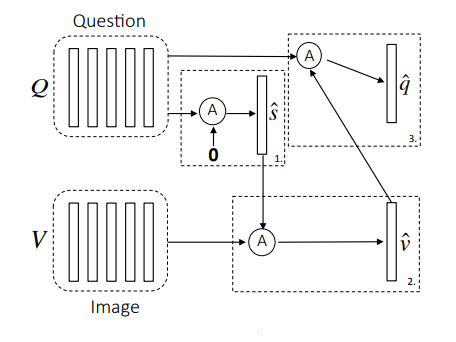

In [ ]:
#Dropout is not useful here
def attention2(X , g, out_dim, dropout_rate,sum=True):

  print(f"X_shape={X.shape}")

  X = tf.keras.layers.Dense(out_dim, activation='tanh',kernel_regularizer=tf.keras.regularizers.l2(l=1e-7))(X)
  #X = Dropout(dropout_rate)(X) 
  print(f"X_shape={X.shape}")

  X = tf.keras.layers.Reshape((-1,out_dim))(X) 
  print(f"X_shape={X.shape}")

  if sum:
    print(f"g_shape={g.shape}")
  
    g = tf.keras.layers.Dense(out_dim, activation='tanh',kernel_regularizer=tf.keras.regularizers.l2(l=1e-7))(g)
    #g = Dropout(dropout_rate)(g)
    print(f"g_shape={g.shape}")

    g = tf.keras.layers.Reshape([-1,out_dim])(g)
    print(f"g_re_shape={g.shape}")

    sum = X+g
    print(f"sum_shape={sum.shape}")

  else:
    sum = X

  sum = tf.keras.layers.Activation('tanh')(sum)
  sum = tf.keras.layers.Dense(1)(sum)
  #sum = Dropout(dropout_rate)(sum)
  print(f"sum_shape={sum.shape}")
  H = tf.keras.layers.Reshape([sum.shape[1]])(sum)
  print(f"H_shape={H.shape}")

  a = tf.keras.layers.Activation('softmax')(H)
  print(f"a_shape={a.shape}")

  a_exp = tf.keras.layers.Reshape([a.shape[1],1])(a) 
  print(f"a-exp_shape={a_exp.shape}")

  att = tf.reduce_sum(a_exp * X , axis = 1)
  print(f"att_shape={att.shape}")
  return att

In [ ]:
from keras.layers import Dense, Activation, Dropout, LSTM, Flatten, Embedding, Multiply, Concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import Model, Input

def RNN(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate):
    input = Input(shape=[max_qs_length],name="Input_qs")
 
    #We tried to use glove but it wasn't helpful in the final model

    #if embedding_matrix != None:
      #PRETRAINED-GLOVE EMBEDDING   
    #x = Embedding(num_words, embedding_dim, 
    #    weights=[embedding_matrix], input_length=seq_length, trainable=False)(input)
      #print('GLOVE')
    #else:
      #LEARNED EMBEDDING

    x = Embedding(num_words,embedding_dim,input_length=seq_length)(input)

    lstm1 = LSTM(units=256, return_sequences=True, input_shape=(seq_length, embedding_dim))(x)
    lstm1 = Dropout(dropout_rate)(lstm1)

    #We tried various types of recurrent layers and stacks, also with residual connections

    #lstm1 = x + lstm1

    #lstm2 = LSTM(units=embedding_dim, return_sequences=True, input_shape=(seq_length, embedding_dim))(lstm1)
    #lstm2 = Dropout(dropout_rate)(lstm2)
    #lstm2 = lstm1 + lstm2
    
    print(f"lstm_out_shape={x.shape}")
    model = Model([input],lstm1)
    return model

#trial to use a custom CNN, trained from scratch, not useful
def img_model_custom(dropout_rate):
  input = Input(shape=[img_h,img_w,3],name="Input_img")
  cnn = Conv2D( 64, (3,3), padding="same")(input)
  cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
  cnn = Conv2D( 128, (3,3), padding="same")(cnn)
  cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
  cnn = Conv2D( 256, (3,3), padding="same")(cnn)
  cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
  model = Model([input],[cnn])
  return model

def img_model(dropout_rate):
    
    vgg = tf.keras.applications.VGG19(
        include_top=False,
        weights="imagenet"
    )
    for l in vgg.layers:
      l.trainable = False
    #vgg.layers.pop(0)
    #vgg.input.name = "Input_img"
    input = Input(shape=[img_h,img_w,3],name="Input_img")
    x=input
    for layer in vgg.layers[1:]:
      x = layer(x)
      #if layer.name == 'block1_pool':
      #  x1 = x
      #if layer.name == 'block2_pool':
      #  x2 = x
      #if layer.name == 'block3_pool':
      #  x3 = x
      #if layer.name == 'block4_pool':
      #  x4 = x

    #we tried to use also lower level features, not useful

    #x = vgg(input)
    #x1 = vgg.get_layer("block1_pool").output
    #x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
    #x2 = vgg.get_layer("block2_pool").output
    #x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)
    #x3 = vgg.get_layer("block3_pool").output
    #x3 = tf.keras.layers.GlobalAveragePooling2D()(x3)
    #x4 = vgg.get_layer("block4_pool").output
    #x4 = tf.keras.layers.GlobalAveragePooling2D()(x4)
    #x = tf.keras.layers.GlobalAveragePooling2D()(x)
    #print(f"x1_shape={x1.shape}")
    #print(f"x2_shape={x2.shape}")
    #print(f"x3_shape={x3.shape}")
    #print(f"x4_shape={x4.shape}")
    #xf = tf.keras.layers.Concatenate()([x1,x2,x3,x4])
    
    
    #x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    
    model = Model([input],[x])
    return model

def vqa_model(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate, num_classes,attention_dim):
    vgg_model = img_model(dropout_rate)
    lstm_model = RNN(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate) 

    s = attention2( lstm_model.outputs[0] , None , attention_dim, dropout_rate, False)

    s = tf.keras.layers.Dropout(dropout_rate)(s)
    
    v = attention2( vgg_model.outputs[0] , s , attention_dim,dropout_rate)
    
    vd = tf.keras.layers.Dropout(dropout_rate)(v)
    
    q = attention2( lstm_model.outputs[0] , vd , attention_dim,dropout_rate)

    q = tf.keras.layers.Dropout(dropout_rate)(q)
    
    att = tf.keras.layers.Dense(num_classes, activation='softmax')(v+q)

    fc_model = Model([vgg_model.input,lstm_model.input],att)
    return fc_model

## Hierarchical co-attention

Implementation of the full hierarchical alternating co-attention presented in the paper. It performs worse than the other methods, due to its larger complexity which lead to a quicker overfitting

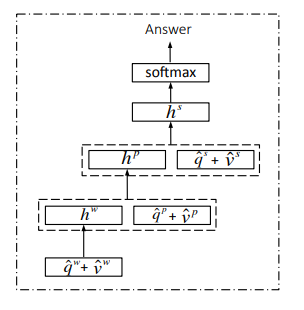

In [ ]:
from keras.layers import Maximum
from keras.layers.convolutional import Conv1D, MaxPooling1D
def RNN_h(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate):
    input = Input(shape=[max_qs_length],name="Input_qs")
 
    #if embedding_matrix != None:
      #PRETRAINED-GLOVE EMBEDDING   
    #x = Embedding(num_words, embedding_dim, 
    #    weights=[embedding_matrix], input_length=seq_length, trainable=False)(input)
      #print('GLOVE')
    #else:
      #LEARNED EMBEDDING
    x = Embedding(num_words,embedding_dim,input_length=seq_length)(input)

    unigram = Conv1D(embedding_dim, kernel_size=1, strides=1, padding="same",activation='tanh')(x)
    bigram = Conv1D(embedding_dim, kernel_size=2, strides=1, padding="same",activation='tanh')(x)
    trigram = Conv1D(embedding_dim, kernel_size=3, strides=1, padding="same",activation='tanh')(x)
    qp = Maximum()([unigram,bigram,trigram])    
    print(f"qp_out_shape={qp.shape}")

    qs = LSTM(units=embedding_dim, return_sequences=True)(qp)
    qs = Dropout(dropout_rate)(qs)
    print(f"qs_out_shape={qs.shape}")

    qw = LSTM(units=embedding_dim, return_sequences=True, input_shape=(seq_length, embedding_dim))(x)
    qw = Dropout(dropout_rate)(qw)
    print(f"qw_out_shape={qw.shape}")
    model = Model([input],[qw,qp,qs])
    return model

In [ ]:
def img_model_h(dropout_rate):
    
    vgg = tf.keras.applications.VGG19(
        include_top=False,
        weights="imagenet"
    )
    for l in vgg.layers:
      l.trainable = False
    input = Input(shape=[img_h,img_w,3],name="Input_img")
    x=input
    for layer in vgg.layers[1:]:
      x = layer(x)

    x = Dropout(dropout_rate)(x)
    model = Model([input],[x])
    return model

In [ ]:
def vqa_model_h(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate, num_classes,attention_dim):
    vgg_model = img_model_h(dropout_rate)
    lstm_model = RNN_h(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate)
    
    s_w = attention2( lstm_model.outputs[0] , None , attention_dim,dropout_rate, False)
    s_w = tf.keras.layers.Dropout(dropout_rate)(s_w)
    v_w = attention2( vgg_model.outputs[0] , s_w , attention_dim,dropout_rate)
    v_w_d = tf.keras.layers.Dropout(dropout_rate)(v_w)
    q_w = attention2( lstm_model.outputs[0] , v_w_d , attention_dim,dropout_rate)
    q_w = tf.keras.layers.Dropout(dropout_rate)(q_w)
    h_w = tf.keras.layers.Dense(attention_dim,activation='tanh')(v_w + q_w)

    s_p = attention2( lstm_model.outputs[1] , None , attention_dim,dropout_rate, False)
    s_p = tf.keras.layers.Dropout(dropout_rate)(s_p)
    v_p = attention2( vgg_model.outputs[0] , s_p , attention_dim,dropout_rate)
    v_p_d = tf.keras.layers.Dropout(dropout_rate)(v_p)
    q_p = attention2( lstm_model.outputs[1] , v_p_d , attention_dim,dropout_rate)
    q_p = tf.keras.layers.Dropout(dropout_rate)(q_p)
    concat_p = tf.keras.layers.Concatenate()([v_p+q_p,h_w])
    h_p = tf.keras.layers.Dense(attention_dim,activation='tanh')(concat_p)

    s_s = attention2( lstm_model.outputs[1] , None , attention_dim, dropout_rate,False)
    s_s = tf.keras.layers.Dropout(dropout_rate)(s_s)
    v_s = attention2( vgg_model.outputs[0] , s_s , attention_dim,dropout_rate)
    v_s_d = tf.keras.layers.Dropout(dropout_rate)(v_s)
    q_s = attention2( lstm_model.outputs[1] , v_s_d , attention_dim,dropout_rate)
    q_s = tf.keras.layers.Dropout(dropout_rate)(q_s)
    concat_s = tf.keras.layers.Concatenate()([v_s+q_s,h_p])
    h_s = tf.keras.layers.Dense(attention_dim,activation='tanh')(concat_s)

    
    att = tf.keras.layers.Dense(num_classes, activation='softmax')(h_s)

    fc_model = Model([vgg_model.input,lstm_model.input],att)
    return fc_model

## Summary

In [ ]:
model = vqa_model(None,len(qs_wtoi)+1,300,max_qs_length,0.5,len(labels_dict),256)

lstm_out_shape=(None, 21, 300)
X_shape=(None, 21, 256)
X_shape=(None, 21, 256)
X_shape=(None, 21, 256)
sum_shape=(None, 21, 1)
H_shape=(None, 21)
a_shape=(None, 21)
a-exp_shape=(None, 21, 1)
att_shape=(None, 256)
X_shape=(None, 14, 14, 512)
X_shape=(None, 14, 14, 256)
X_shape=(None, 196, 256)
g_shape=(None, 256)
g_shape=(None, 256)
g_re_shape=(None, 1, 256)
sum_shape=(None, 196, 256)
sum_shape=(None, 196, 1)
H_shape=(None, 196)
a_shape=(None, 196)
a-exp_shape=(None, 196, 1)
att_shape=(None, 256)
X_shape=(None, 21, 256)
X_shape=(None, 21, 256)
X_shape=(None, 21, 256)
g_shape=(None, 256)
g_shape=(None, 256)
g_re_shape=(None, 1, 256)
sum_shape=(None, 21, 256)
sum_shape=(None, 21, 1)
H_shape=(None, 21)
a_shape=(None, 21)
a-exp_shape=(None, 21, 1)
att_shape=(None, 256)


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_img (InputLayer)          [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           multiple             1792        Input_img[0][0]                  
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           multiple             36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      multiple             0           block1_conv2[1][0]               
____________________________________________________________________________________________

# Sparse Focal Loss

We tried to use this alternative loss function which allows to weight the classes and should be useful in unbalanced dataset, like this one. We tried to reduce in various way the weights of 'yes' and 'no' answers, but it wasn't helpful

In [ ]:
"""Multiclass focal loss implementation."""
#    __                          _     _
#   / _|                        | |   | |
#  | |_    ___     ___    __ _  | |   | |   ___    ___   ___
#  |  _|  / _ \   / __|  / _` | | |   | |  / _ \  / __| / __|
#  | |   | (_) | | (__  | (_| | | |   | | | (_) | \__ \ \__ \
#  |_|    \___/   \___|  \__,_| |_|   |_|  \___/  |___/ |___/
 
import itertools
from typing import Any, Optional
 
import tensorflow as tf
 
_EPSILON = tf.keras.backend.epsilon()
 
 
def sparse_categorical_focal_loss(y_true, y_pred, gamma, *,
                                  class_weight: Optional[Any] = None,
                                  from_logits: bool = False, axis: int = -1
                                  ) -> tf.Tensor:
    r"""Focal loss function for multiclass classification with integer labels.
    This loss function generalizes multiclass softmax cross-entropy by
    introducing a hyperparameter called the *focusing parameter* that allows
    hard-to-classify examples to be penalized more heavily relative to
    easy-to-classify examples.
    See :meth:`~focal_loss.binary_focal_loss` for a description of the focal
    loss in the binary setting, as presented in the original work [1]_.
    In the multiclass setting, with integer labels :math:`y`, focal loss is
    defined as
    .. math::
        L(y, \hat{\mathbf{p}})
        = -\left(1 - \hat{p}_y\right)^\gamma \log(\hat{p}_y)
    where
    *   :math:`y \in \{0, \ldots, K - 1\}` is an integer class label (:math:`K`
        denotes the number of classes),
    *   :math:`\hat{\mathbf{p}} = (\hat{p}_0, \ldots, \hat{p}_{K-1})
        \in [0, 1]^K` is a vector representing an estimated probability
        distribution over the :math:`K` classes,
    *   :math:`\gamma` (gamma, not :math:`y`) is the *focusing parameter* that
        specifies how much higher-confidence correct predictions contribute to
        the overall loss (the higher the :math:`\gamma`, the higher the rate at
        which easy-to-classify examples are down-weighted).
    The usual multiclass softmax cross-entropy loss is recovered by setting
    :math:`\gamma = 0`.
    Parameters
    ----------
    y_true : tensor-like
        Integer class labels.
    y_pred : tensor-like
        Either probabilities or logits, depending on the `from_logits`
        parameter.
    gamma : float or tensor-like of shape (K,)
        The focusing parameter :math:`\gamma`. Higher values of `gamma` make
        easy-to-classify examples contribute less to the loss relative to
        hard-to-classify examples. Must be non-negative. This can be a
        one-dimensional tensor, in which case it specifies a focusing parameter
        for each class.
    class_weight: tensor-like of shape (K,)
        Weighting factor for each of the :math:`k` classes. If not specified,
        then all classes are weighted equally.
    from_logits : bool, optional
        Whether `y_pred` contains logits or probabilities.
    axis : int, optional
        Channel axis in the `y_pred` tensor.
    Returns
    -------
    :class:`tf.Tensor`
        The focal loss for each example.
    Examples
    --------
    This function computes the per-example focal loss between a one-dimensional
    integer label vector and a two-dimensional prediction matrix:
    >>> import numpy as np
    >>> from focal_loss import sparse_categorical_focal_loss
    >>> y_true = [0, 1, 2]
    >>> y_pred = [[0.8, 0.1, 0.1], [0.2, 0.7, 0.1], [0.2, 0.2, 0.6]]
    >>> loss = sparse_categorical_focal_loss(y_true, y_pred, gamma=2)
    >>> np.set_printoptions(precision=3)
    >>> print(loss.numpy())
    [0.009 0.032 0.082]
    Warnings
    --------
    This function does not reduce its output to a scalar, so it cannot be passed
    to :meth:`tf.keras.Model.compile` as a `loss` argument. Instead, use the
    wrapper class :class:`~focal_loss.SparseCategoricalFocalLoss`.
    References
    ----------
    .. [1] T. Lin, P. Goyal, R. Girshick, K. He and P. Dollár. Focal loss for
        dense object detection. IEEE Transactions on Pattern Analysis and
        Machine Intelligence, 2018.
        (`DOI <https://doi.org/10.1109/TPAMI.2018.2858826>`__)
        (`arXiv preprint <https://arxiv.org/abs/1708.02002>`__)
    See Also
    --------
    :meth:`~focal_loss.SparseCategoricalFocalLoss`
        A wrapper around this function that makes it a
        :class:`tf.keras.losses.Loss`.
    """
    # Process focusing parameter
    gamma = tf.convert_to_tensor(gamma, dtype=tf.dtypes.float32)
    gamma_rank = gamma.shape.rank
    scalar_gamma = gamma_rank == 0
 
    # Process class weight
    if class_weight is not None:
        class_weight = tf.convert_to_tensor(class_weight,
                                            dtype=tf.dtypes.float32)
 
    # Process prediction tensor
    y_pred = tf.convert_to_tensor(y_pred)
    y_pred_rank = y_pred.shape.rank
    if y_pred_rank is not None:
        axis %= y_pred_rank
        if axis != y_pred_rank - 1:
            # Put channel axis last for sparse_softmax_cross_entropy_with_logits
            perm = list(itertools.chain(range(axis),
                                        range(axis + 1, y_pred_rank), [axis]))
            y_pred = tf.transpose(y_pred, perm=perm)
    elif axis != -1:
        raise ValueError(
            f'Cannot compute sparse categorical focal loss with axis={axis} on '
            'a prediction tensor with statically unknown rank.')
    y_pred_shape = tf.shape(y_pred)
 
    # Process ground truth tensor
    y_true = tf.dtypes.cast(y_true, dtype=tf.dtypes.int64)
    y_true_rank = y_true.shape.rank
 
    if y_true_rank is None:
        raise NotImplementedError('Sparse categorical focal loss not supported '
                                  'for target/label tensors of unknown rank')
 
    reshape_needed = (y_true_rank is not None and y_pred_rank is not None and
                      y_pred_rank != y_true_rank + 1)
    if reshape_needed:
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1, y_pred_shape[-1]])
 
    if from_logits:
        logits = y_pred
        probs = tf.nn.softmax(y_pred, axis=-1)
    else:
        probs = y_pred
        logits = tf.math.log(tf.clip_by_value(y_pred, _EPSILON, 1 - _EPSILON))
 
    xent_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y_true,
        logits=logits,
    )
 
    y_true_rank = y_true.shape.rank
    probs = tf.gather(probs, y_true, axis=-1, batch_dims=y_true_rank)
    if not scalar_gamma:
        gamma = tf.gather(gamma, y_true, axis=0, batch_dims=y_true_rank)
    focal_modulation = (1 - probs) ** gamma
    loss = focal_modulation * xent_loss
 
    if class_weight is not None:
        class_weight = tf.gather(class_weight, y_true, axis=0,
                                 batch_dims=y_true_rank)
        loss *= class_weight
 
    if reshape_needed:
        loss = tf.reshape(loss, y_pred_shape[:-1])
 
    return loss
 
 
@tf.keras.utils.register_keras_serializable()
class SparseCategoricalFocalLoss(tf.keras.losses.Loss):
    r"""Focal loss function for multiclass classification with integer labels.
    This loss function generalizes multiclass softmax cross-entropy by
    introducing a hyperparameter :math:`\gamma` (gamma), called the
    *focusing parameter*, that allows hard-to-classify examples to be penalized
    more heavily relative to easy-to-classify examples.
    This class is a wrapper around
    :class:`~focal_loss.sparse_categorical_focal_loss`. See the documentation
    there for details about this loss function.
    Parameters
    ----------
    gamma : float or tensor-like of shape (K,)
        The focusing parameter :math:`\gamma`. Higher values of `gamma` make
        easy-to-classify examples contribute less to the loss relative to
        hard-to-classify examples. Must be non-negative. This can be a
        one-dimensional tensor, in which case it specifies a focusing parameter
        for each class.
    class_weight: tensor-like of shape (K,)
        Weighting factor for each of the :math:`k` classes. If not specified,
        then all classes are weighted equally.
    from_logits : bool, optional
        Whether model prediction will be logits or probabilities.
    **kwargs : keyword arguments
        Other keyword arguments for :class:`tf.keras.losses.Loss` (e.g., `name`
        or `reduction`).
    Examples
    --------
    An instance of this class is a callable that takes a rank-one tensor of
    integer class labels `y_true` and a tensor of model predictions `y_pred` and
    returns a scalar tensor obtained by reducing the per-example focal loss (the
    default reduction is a batch-wise average).
    >>> from focal_loss import SparseCategoricalFocalLoss
    >>> loss_func = SparseCategoricalFocalLoss(gamma=2)
    >>> y_true = [0, 1, 2]
    >>> y_pred = [[0.8, 0.1, 0.1], [0.2, 0.7, 0.1], [0.2, 0.2, 0.6]]
    >>> loss_func(y_true, y_pred)
    <tf.Tensor: shape=(), dtype=float32, numpy=0.040919524>
    Use this class in the :mod:`tf.keras` API like any other multiclass
    classification loss function class that accepts integer labels found in
    :mod:`tf.keras.losses` (e.g.,
    :class:`tf.keras.losses.SparseCategoricalCrossentropy`:
    .. code-block:: python
        # Typical usage
        model = tf.keras.Model(...)
        model.compile(
            optimizer=...,
            loss=SparseCategoricalFocalLoss(gamma=2),  # Used here like a tf.keras loss
            metrics=...,
        )
        history = model.fit(...)
    See Also
    --------
    :meth:`~focal_loss.sparse_categorical_focal_loss`
        The function that performs the focal loss computation, taking a label
        tensor and a prediction tensor and outputting a loss.
    """
 
    def __init__(self, gamma, class_weight: Optional[Any] = None,
                 from_logits: bool = False, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.class_weight = class_weight
        self.from_logits = from_logits
 
    def get_config(self):
        """Returns the config of the layer.
        A layer config is a Python dictionary containing the configuration of a
        layer. The same layer can be re-instantiated later (without its trained
        weights) from this configuration.
        Returns
        -------
        dict
            This layer's config.
        """
        config = super().get_config()
        config.update(gamma=self.gamma, class_weight=self.class_weight,
                      from_logits=self.from_logits)
        return config
 
    def call(self, y_true, y_pred):
        """Compute the per-example focal loss.
        This method simply calls
        :meth:`~focal_loss.sparse_categorical_focal_loss` with the appropriate
        arguments.
        Parameters
        ----------
        y_true : tensor-like, shape (N,)
            Integer class labels.
        y_pred : tensor-like, shape (N, K)
            Either probabilities or logits, depending on the `from_logits`
            parameter.
        Returns
        -------
        :class:`tf.Tensor`
            The per-example focal loss. Reduction to a scalar is handled by
            this layer's
            :meth:`~focal_loss.SparseCateogiricalFocalLoss.__call__` method.
        """
        return sparse_categorical_focal_loss(y_true=y_true, y_pred=y_pred,
                                             class_weight=self.class_weight,
                                             gamma=self.gamma,
                                             from_logits=self.from_logits)

ValueError: ignored

# Training

In [ ]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy()

#trial with focal loss, reducing the weight of 'yes' and 'no' answers (most common answers)

#class_weights = np.ones([58])
#class_weights[57]=0.5
#class_weights[33]=0.5
#loss = SparseCategoricalFocalLoss(gamma=2,class_weight=class_weights)

# learning rate
lr = 4e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = '/content/drive/My Drive/Colab Notebooks/CHALLENGE3'
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

exp_name = 'VQA_CoAttentionDrop0.5red256L2Final'

exp_dir = os.path.join(exps_dir, exp_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True,save_best_only=False,verbose=1,monitor='val_accuracy')
callbacks.append(ckpt_callback)

# ----------------

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
#callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
    callbacks.append(es_callback)

# ---------------------------------

## Best checkpoints

### Best

0.66054 on test
https://drive.google.com/file/d/11mR3ptHG9-sRlziblcHnDGI8YPYLAbuV/view?usp=sharing

In [ ]:
#co-attention model, 15+8 epochs, bs=32, lr=4e-4, opt=adam, no data augmentation, dropout=0.5, L2=10-7 loss: 0.5667 - accuracy: 0.7655 - val_loss: 1.0465 - val_accuracy: 0.6591

model.load_weights('/content/drive/My Drive/Colab Notebooks/CHALLENGE3/VQA_CoAttentionDrop0.5red256L2_Jan27_17-22-41/ckpts/cp_08.ckpt')

### Final retraining on 99% of dataset

best 0.67372, 23+6+1 epochs
https://drive.google.com/file/d/1-J1Ffhh9zXL7Rqu2qfrqMugBYdJU1qiH/view?usp=sharing

In [ ]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/CHALLENGE3/VQA_CoAttentionDrop0.5red256L2Final_Jan31_08-12-02/ckpts/cp_01.ckpt')

## Fit

In [ ]:
#evening 27/01
model.fit(x=train_dataset,
          epochs=15,
          steps_per_epoch=len(dataset)//bs,
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid)//bs, 
          callbacks=callbacks)

Epoch 1/15
1562/1562 [==============================] - 1324s 847ms/step - loss: 0.6318 - accuracy: 0.7379 - val_loss: 0.9622 - val_accuracy: 0.6542

Epoch 00001: val_accuracy improved from 0.65205 to 0.65420, saving model to /content/drive/My Drive/Colab Notebooks/CHALLENGE3/VQA_CoAttentionDrop0.5red256L2_Jan27_17-22-41/ckpts/cp_01.ckpt
Epoch 2/15
1562/1562 [==============================] - 1321s 846ms/step - loss: 0.6198 - accuracy: 0.7421 - val_loss: 0.9694 - val_accuracy: 0.6548

Epoch 00002: val_accuracy improved from 0.65420 to 0.65477, saving model to /content/drive/My Drive/Colab Notebooks/CHALLENGE3/VQA_CoAttentionDrop0.5red256L2_Jan27_17-22-41/ckpts/cp_02.ckpt
Epoch 3/15
1562/1562 [==============================] - 1327s 850ms/step - loss: 0.6114 - accuracy: 0.7469 - val_loss: 0.9982 - val_accuracy: 0.6551

Epoch 00003: val_accuracy improved from 0.65477 to 0.65511, saving model to /content/drive/My Drive/Colab Notebooks/CHALLENGE3/VQA_CoAttentionDrop0.5red256L2_Jan27_17-22-

# Prediction

In [ ]:
def read_questions_for_prediction(path):
  with open(path, 'r') as file:
    qs = json.load(file)
  ids = [q for q in qs]
  texts = [qs[q]['question'] for q in qs]
  image_ids = [qs[q]['image_id'] for q in qs]
  return (ids, texts, image_ids)

In [ ]:
test_ids, test_qs, test_image_ids = read_questions_for_prediction('/content/VQA_Dataset/test_questions.json')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create Tokenizer to convert words to integers
#test_tokenizer = Tokenizer(num_words= MAX_NUM_WORDS)
#test_tokenizer.fit_on_texts(test_qs)
test_tokenized = qs_tokenizer.texts_to_sequences(test_qs)

qs_test_wtoi = qs_tokenizer.word_index
print('Total tokenizer words:', len(qs_test_wtoi))

max_qs_test_length = max(len(sentence) for sentence in test_tokenized)
print('Max test qs sentence length:', max_qs_test_length)

Total test qs words: 4640
Max test qs sentence length: 18


## Check if all test words are covered in the training set

In [ ]:
test_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
test_tokenizer.fit_on_texts(test_qs)
print(f"Total number of test words={len(test_tokenizer.word_index)}")

Total number of test words=1373


In [ ]:
c=0
for t_w in test_tokenizer.word_index.keys():
  if  t_w in qs_tokenizer.word_index:
    c+=1
print(f"Number of test words covered in training set={c}")

Number of test words covered in training set=1373


In [ ]:
c = 0
for i in test_image_ids:
  if (i in train_image_ids) or (i in valid_image_ids):
    c += 1
print(f"Number of test images already covered in the training set={c}")
print(f"Total number of test images={len(test_image_ids)}")

Number of test images already covered in the training set=5627
Total number of test images=6372


## Test Padding

In [ ]:
# Pad to max qs sentence length
test_qs_inputs = pad_sequences(test_tokenized, maxlen=max_qs_length)

print("Test QS inputs shape:", test_qs_inputs.shape)

Test QS inputs shape: (6372, 21)


## Test Prediction

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input 

results = {}

for i in range(len(test_qs_inputs)):
  print(i)
  id = test_ids[i]
  qs = test_qs_inputs[i]
  image_id = test_image_ids[i]
  img_path = os.path.join('/content/VQA_Dataset/Images',image_id+'.png')
  img = Image.open(img_path).convert('RGB') #convert is necessary, otherwise PNG have 4 channels

  img = img.resize([img_h, img_w])
  img_arr = np.array(img)
  img_arr = preprocess_input(img_arr)
  img_arr = np.expand_dims(img_arr, 0)

  qs = np.expand_dims(qs, 0)

  out_sigmoid = model.predict({'Input_img':img_arr,'Input_qs':qs})

  predicted_class = tf.argmax(out_sigmoid, -1)
  predicted_class = predicted_class[0, ...]

  results[id] = predicted_class.numpy()



Output streaming troncato alle ultime 5000 righe.
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561


Visual verification of predictions

In [ ]:
j=-1

0
Q:how is the weather  A:sunny


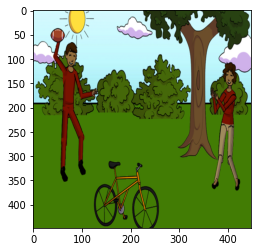

In [ ]:
j+=1
print(j)

image_id = test_image_ids[j]
img_path = os.path.join('/content/VQA_Dataset/Images',image_id+'.png')
img = Image.open(img_path).convert('RGB') #convert is necessary, otherwise PNG have 4 channels

img = img.resize([img_h, img_w])
img_arr_or = np.array(img)
img_arr = preprocess_input(img_arr_or)
img_arr = np.expand_dims(img_arr, 0)

qs = test_qs_inputs[j]
qs = np.expand_dims(qs, 0)

out_sigmoid = model.predict({'Input_img':img_arr,'Input_qs':qs})

predicted_class = tf.argmax(out_sigmoid, -1)
predicted_class = predicted_class[0, ...]

answer = predicted_class.numpy()

qs_string = ""
qs_itow = {v:k for k, v in qs_wtoi.items()}
for i in qs[0]:
  if i > 0:
    word = qs_itow[i]
    qs_string += word + " "

answer_string = (list(labels_dict.keys())[list(labels_dict.values()).index(answer)])

print(f"Q:{qs_string} A:{answer_string}")

plt.imshow(img_arr_or)

In [ ]:
results

{'169491': 49,
 '33711': 14,
 '100051': 2,
 '15271': 57,
 '13291': 2,
 '146571': 2,
 '145202': 2,
 '166652': 33,
 '1282': 57,
 '71512': 57,
 '24691': 57,
 '187130': 28,
 '31122': 2,
 '125731': 33,
 '125732': 33,
 '174961': 33,
 '125980': 28,
 '131642': 57,
 '135272': 33,
 '195130': 1,
 '195131': 57,
 '195132': 7,
 '11892': 38,
 '136812': 2,
 '84622': 5,
 '117291': 2,
 '21252': 57,
 '64220': 50,
 '84430': 57,
 '113740': 33,
 '113742': 2,
 '41071': 20,
 '27502': 57,
 '49681': 2,
 '49682': 57,
 '147491': 57,
 '19671': 2,
 '95480': 53,
 '138791': 57,
 '163772': 3,
 '96300': 57,
 '2350': 56,
 '2351': 2,
 '72000': 33,
 '152732': 44,
 '166402': 33,
 '131030': 33,
 '25160': 57,
 '25162': 57,
 '26752': 33,
 '26750': 2,
 '108460': 57,
 '148750': 10,
 '142411': 57,
 '92520': 57,
 '30542': 2,
 '91362': 2,
 '48642': 1,
 '93010': 33,
 '103052': 33,
 '149800': 11,
 '123661': 39,
 '123532': 41,
 '110692': 57,
 '185080': 1,
 '185082': 39,
 '105361': 1,
 '45442': 57,
 '160190': 54,
 '39651': 57,
 '14553

Distribution of predicted answers, to verify that the model is effectively able to consider all of them and it's not just predicted yes and no (which could have been possible, considering their prevalence in the dataset)

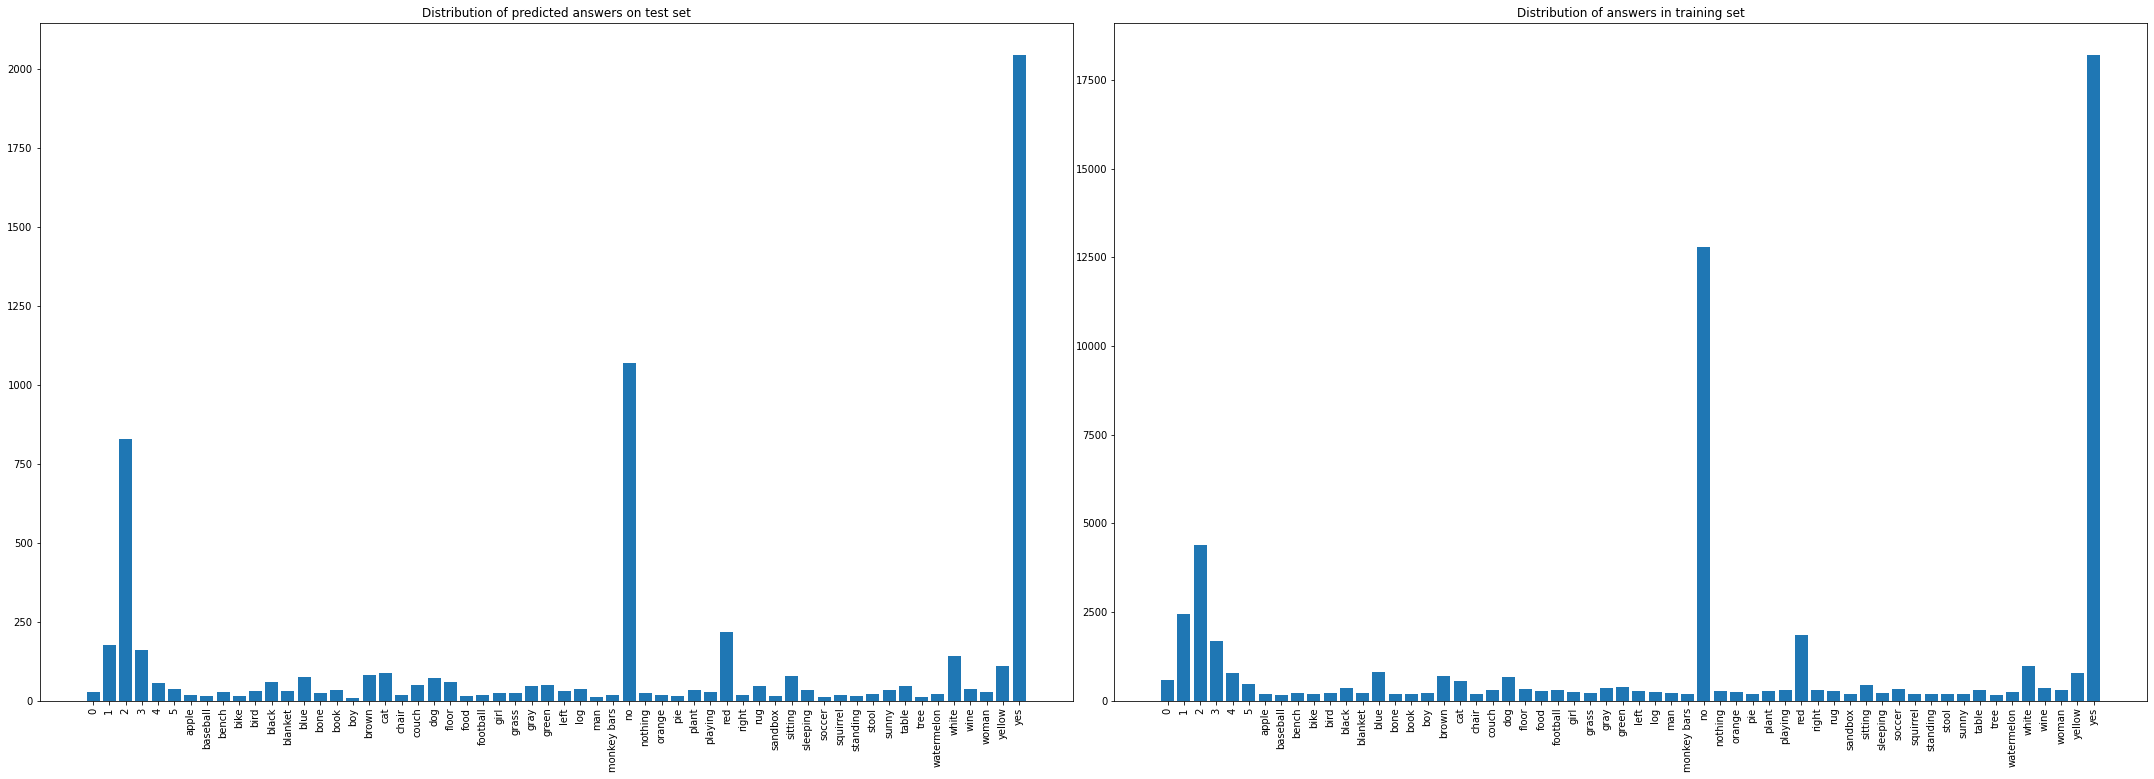

In [ ]:
answers_count = np.zeros([58])
for (k,v) in results.items():
  answers_count[v] += 1

train_answers_count = np.zeros([58])
for a in train_answers:
  train_answers_count[labels_dict[a]] += 1

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
fig.tight_layout()

axes[0].bar(np.arange(len(answers_count)),answers_count) 
axes[0].set_xticks(range(0,58))
axes[0].set_xticklabels(labels_dict.keys(),rotation='vertical')
axes[0].title.set_text('Distribution of predicted answers on test set')

axes[1].bar(np.arange(len(train_answers_count)),train_answers_count) 
axes[1].set_xticks(range(0,58))
axes[1].set_xticklabels(labels_dict.keys(),rotation='vertical')
axes[1].title.set_text('Distribution of answers in training set')

In [ ]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
create_csv(results)